# Persiapaan Awal

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

In [2]:
def map_sentiment(sentiment):
    if sentiment == 1:
        return 'positif'
    elif sentiment == 0:
        return 'netral'
    else:
        return 'negatif'

In [3]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y

In [4]:
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [5]:
df = pd.read_csv('sentiment_1000.csv')
df['sentimen'] = df['sentimen'].map(map_sentiment)
df.head(10)

,content,sentimen
0,bacapres koalisi perubahan anies baswedan bert...,positif
1,calon presiden bacapres ganjar pranowo mengawa...,positif
2,bacapres ganjar pranowo bertemu seniman musisi...,positif
3,bacapres koalisi perubahan anies baswedan mere...,positif
4,bacapres koalisi perubahan anies baswedan meny...,positif
5,anies baswedan peringkat ketiga hasil survei a...,positif
6,relawan solidaritas ulama muda jokowi samawi m...,positif
7,bacapres koalisi indonesia maju kim prabowo su...,positif
8,bacapres ganjar pranowo mahfud md akrab mengha...,positif
9,baliho bergambar ketua umum partai gerindra pr...,positif


In [6]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)

In [7]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]

In [8]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

In [9]:
# Bag of Words (BoW) features
count_vectorizer, count_train_features = tfidf_extractor(x_train, ngram_range=(1, 1))  # Unigram features
count_test_features = count_vectorizer.transform(x_test)

In [10]:
# Combine TF-IDF and BoW features
combined_train_features = hstack([tfidf_train_features, count_train_features])
combined_test_features = hstack([tfidf_test_features, count_test_features])

### World Cloud

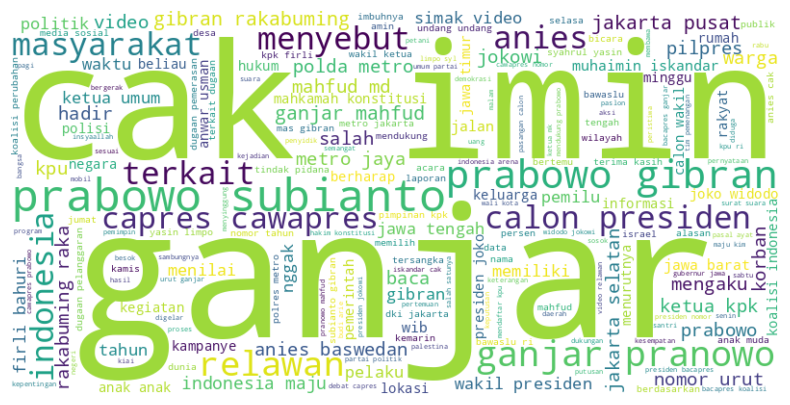

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all texts into one string
all_texts = ' '.join(df['content'])

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_texts)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### LSA

In [12]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Define the number of topics
num_topics = 10

# Perform LSA
lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_train_features = lsa_model.fit_transform(tfidf_train_features)

# Get feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to print the most important words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Print the most important words for each topic
print("LSA Topics:")
print_top_words(lsa_model, feature_names, 10)

LSA Topics:

Topic #0:
prabowo gibran ganjar kpk firli anies indonesia jokowi relawan mahfud

Topic #1:
firli kpk polda polda metro bahuri firli bahuri metro metro jaya ketua kpk pemerasan

Topic #2:
anies imin cak cak imin ganjar mahfud muhaimin kpu amin perubahan

Topic #3:
anwar mk konstitusi putusan hakim usman anwar usman mkmk mahkamah mahkamah konstitusi

Topic #4:
anies imin cak cak imin prabowo gibran muhaimin perubahan amin baswedan

Topic #5:
israel hamas gaza penembakan tiket ghisca serangan korban palestina tewas

Topic #6:
tiket ghisca coldplay penipuan metro jakarta polres konser polres metro metro susatyo

Topic #7:
projo jokowi rakernas budi arie arie budi kriteria anies tiket dukungan

Topic #8:
bawaslu projo pemilu kampanye pelanggaran bagja budi rakernas bawaslu ri arie

Topic #9:
sorong kpk ott barat daya papua barat papua anies yan daya bpk


In [13]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# # Function to generate word cloud for each topic
# def generate_wordclouds(model, feature_names, n_top_words):
#     for topic_idx, topic in enumerate(model.components_):
#         word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[:-n_top_words - 1:-1]}
#         wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq)
#         plt.figure(figsize=(10, 5))
#         plt.imshow(wordcloud, interpolation='bilinear')
#         plt.axis("off")
#         plt.title(f"Topic #{topic_idx}")
#         plt.show()

# # Generate word clouds for LSA topics
# generate_wordclouds(lsa_model, feature_names, 10)


## Model Naiye Bayes

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

In [15]:
# Define function to train and evaluate Naive Bayes classifier
def train_and_evaluate(classifier, train_features, train_labels, test_features, test_labels):
    # Train the classifier
    classifier.fit(train_features, train_labels)
    
    # Predictions
    predictions = classifier.predict(test_features)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)
    
    # Calculate F1 score
    f1 = f1_score(test_labels, predictions, average='weighted')
    
    return accuracy, f1

#### Tanpa Parameter

In [16]:
# Initialize Naive Bayes classifier
model_naiye_tanpa_parameter = MultinomialNB()

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_naiye_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_naiye_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_naiye_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 67.33333333333333
TF-IDF Vectorization F1 Score: 67.28085214950886
Bag of Words (BoW) Accuracy: 69.0
Bag of Words (BoW) F1 Score: 68.7292681966802
Combined TF-IDF and BoW Accuracy: 69.33333333333334
Combined TF-IDF and BoW F1 Score: 68.98885458580487


#### Pakai Parameter

In [17]:
# Initialize Naive Bayes classifier
model_naiye_parameter = MultinomialNB(alpha= 0.1,fit_prior=True)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_naiye_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_naiye_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_naiye_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 68.66666666666667
TF-IDF Vectorization F1 Score: 68.23154454764362
Bag of Words (BoW) Accuracy: 68.33333333333333
Bag of Words (BoW) F1 Score: 67.35197985302291
Combined TF-IDF and BoW Accuracy: 66.66666666666666
Combined TF-IDF and BoW F1 Score: 65.93681202314123


## Model SVM

In [18]:
from sklearn.svm import SVC

#### Tanpa Parameter Sederhana

In [19]:
# Initialize SVM
model_svm_tanpa_parameter =  SVC(kernel='linear', random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_svm_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_svm_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_svm_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 70.0
TF-IDF Vectorization F1 Score: 69.54325199399827
Bag of Words (BoW) Accuracy: 70.0
Bag of Words (BoW) F1 Score: 69.49775588396278
Combined TF-IDF and BoW Accuracy: 65.33333333333333
Combined TF-IDF and BoW F1 Score: 64.71948933495173


#### Pakai Parameter

In [20]:
# Initialize SVM
model_svm_parameter =  SVC(C=10, gamma=0.1, kernel='sigmoid')

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_svm_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_svm_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_svm_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 70.0
TF-IDF Vectorization F1 Score: 69.54325199399827
Bag of Words (BoW) Accuracy: 70.0
Bag of Words (BoW) F1 Score: 69.49775588396278
Combined TF-IDF and BoW Accuracy: 65.66666666666666
Combined TF-IDF and BoW F1 Score: 65.05500496575975


## Model Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression


#### Tanpa Parameter

In [22]:
# Initialize Naive Bayes classifier
model_lr_tanpa_parameter = LogisticRegression(random_state=42,max_iter=1000)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_lr_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_lr_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_lr_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 69.0
TF-IDF Vectorization F1 Score: 68.22232816003672
Bag of Words (BoW) Accuracy: 69.66666666666667
Bag of Words (BoW) F1 Score: 69.03542105377782
Combined TF-IDF and BoW Accuracy: 68.33333333333333
Combined TF-IDF and BoW F1 Score: 67.44280831212764


#### Parameter

In [25]:
# Initialize Naive Bayes classifier
model_lr_parameter = LogisticRegression(C=1,penalty="l2",random_state=42,max_iter=1000)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_lr_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_lr_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_lr_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 69.0
TF-IDF Vectorization F1 Score: 68.22232816003672
Bag of Words (BoW) Accuracy: 69.66666666666667
Bag of Words (BoW) F1 Score: 69.03542105377782
Combined TF-IDF and BoW Accuracy: 68.33333333333333
Combined TF-IDF and BoW F1 Score: 67.44280831212764


## Model Random Forest 

In [26]:
from sklearn.ensemble import RandomForestClassifier

#### Tanpa Parameter

In [27]:
# Initialize SVM
model_rfc_tanpa_parameter =  RandomForestClassifier(random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_rfc_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_rfc_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_rfc_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 66.0
TF-IDF Vectorization F1 Score: 65.84934373359333
Bag of Words (BoW) Accuracy: 67.33333333333333
Bag of Words (BoW) F1 Score: 67.00314102564103
Combined TF-IDF and BoW Accuracy: 68.33333333333333
Combined TF-IDF and BoW F1 Score: 67.86982808682767


#### Parameter

In [28]:
# Initialize SVM
model_rfc_parameter =  RandomForestClassifier(min_samples_split=10,min_samples_leaf=2,n_estimators=150, random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_rfc_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_rfc_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_rfc_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 69.0
TF-IDF Vectorization F1 Score: 68.67658991742296
Bag of Words (BoW) Accuracy: 67.0
Bag of Words (BoW) F1 Score: 66.53962418300654
Combined TF-IDF and BoW Accuracy: 67.66666666666666
Combined TF-IDF and BoW F1 Score: 66.9718775847808


## Model Ensemble Learning

In [29]:
# Mengambil model terbaik dari hasil tuning
best_model_naive_bayes = model_naiye_parameter
best_model_svm = model_svm_parameter
best_model_random_forest = model_rfc_parameter
best_model_logistic_regression = model_lr_parameter

In [30]:
from sklearn.ensemble import VotingClassifier

#### 4 Model

In [32]:
# Membuat model ensemble
ensemble_model = VotingClassifier(estimators=[
    ('naive_bayes', best_model_naive_bayes),
    ('svm', best_model_svm),
    ('random_forest', best_model_random_forest),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

In [33]:
# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(ensemble_model , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(ensemble_model , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(ensemble_model , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 72.0
TF-IDF Vectorization F1 Score: 71.63372945304238
Bag of Words (BoW) Accuracy: 70.66666666666667
Bag of Words (BoW) F1 Score: 70.16516949265778
Combined TF-IDF and BoW Accuracy: 68.66666666666667
Combined TF-IDF and BoW F1 Score: 68.10662779163786
